# Metaflow Overview
Metaflow is used to organize data products uploaded
to the MinIO data store. Metaflow `Flows` consist of
a series of steps defined by the data engineer to
process data, tag the data with relavant metadata, 
and upload data products to MinIO. 

# Metaflow Documentation
https://docs.metaflow.org/metaflow/basics

# Imports/Setup

In [ ]:
import opal.flow
import metaflow
import pandas as pd
from metaflow.cards import get_cards

# Get the MinIO FileSystem Object for Later Use
fs = opal.flow.minio_s3fs()

# Create a Flow

- See https://docs.metaflow.org/metaflow/basics for a detailed walk through for creating a flow using `metaflow.FlowSpec`
- `OPALFlowSpec` is used for OPAL and is a wrapper class that inherits from `metaflow.FlowSpec`
- `OPALFlowSpec` has all the functionality of `metaflow.FlowSpec` plus additional convience functions 

## Example Flow

- Save the contents below as a separate file named `create_tables_flow.py`
- Note the comments for further clarity

```python
import metaflow
from metaflow import step, card
import pandas as pd
import tempfile
import os
from opal.flow import OpalFlowSpec

# This flow generates two tables and saves them to the MinIO datastore
class CreateTablesFlow(OpalFlowSpec):
    # table_length is an input parameter passed when running this flow
    table_length_1 = metaflow.Parameter(
        "table_length_1",
        help="Length Of Table 1 to Create",
        required=True
    )
    
    table_length_2 = metaflow.Parameter(
        "table_length_2",
        help="Length Of Table 2 to Create",
        required=True
    )
    
    @step # the '@step' decorator is required
    def start(self): # 'start' and 'end' steps are required
        # Comments like the one below are attached to their function
        # and are visible from cards, cli tools, etc
        """
        Get the table_length parameters and convert them to integers
        """
        self.n_int_1 = int(self.table_length_1)
        self.n_int_2 = int(self.table_length_2)
        
        # self.next points to the next step
        self.next(self.create_tables) 
        
    @step 
    def create_tables(self):
        """
        Make tables
        """
        df1 = pd.DataFrame({'data': list(range(self.n_int_1))})
        df2 = pd.DataFrame({'data': list(range(self.n_int_2))})
        temp_file_1 = tempfile.gettempdir()
        temp_file_2 = tempfile.gettempdir()
        self.path1 = os.path.join(temp_file_1, f"table_1.parquet")
        self.path2 = os.path.join(temp_file_2, f"table_2.parquet")
        df1.to_parquet(self.path1)
        df2.to_parquet(self.path2)
        
        self.next(self.upload_tables)
        
    @step
    def upload_tables(self):
        """
        Upload the tables to MinIO
        """
        # self.upload(path, reference)
        #    path: The local path to the file being uploaded
        #    reference: A tag that will be used to reference the Data
        self.upload(self.path1, "table1")
        self.upload(self.path2, "table2") 
        self.next(self.save_metadata)
        
    @step
    def save_metadata(self):
        """
        Save Metadata
        """
        # All items saved to self will 
        # be saved with the Flow Run
        self.metadata_1 = 1
        self.metadata_dictionary = {'key': 1}
        self.next(self.end)
        
    @card # The card decorator saves data to generate a nice HTML file
    @step
    def end(self):
        """
        Print All Done
        """
        print("All done!")

if __name__ == "__main__":
    CreateTablesFlow()
```

## Access all options that can be run on the flow
- This can be run only after the above code is saved as `create_tables_flow.py` in the current working directory

In [ ]:
!python create_tables_flow.py --help

## Show Steps of the Flow

In [ ]:
!python create_tables_flow.py show

## Run Flow
- Note that the pylint step can be skipped by adding the '--no-pylint' parameter

In [ ]:
# Pass the desired length for the first and second
# tables to be created
!python create_tables_flow.py run --table_length_1=4 --table_length_2=10

# Access the Run

## Get all Runs from the create_tables Flow

In [ ]:
create_tables_runs = metaflow.Flow("CreateTablesFlow")
# Note that there is an ID associated with every run instance of the CreateTables Flow
print(list(create_tables_runs))

## Get the latest create_tables Run

In [ ]:
latest_create_tables_run = create_tables_runs.latest_successful_run

# Look through the uploaded data files associated with the run
print(latest_create_tables_run.data.data_files)  

## Read back the uploaded files

In [ ]:
df1 = pd.read_parquet(latest_create_tables_run.data.data_files['table1'], filesystem=fs)
df2 = pd.read_parquet(latest_create_tables_run.data.data_files['table2'], filesystem=fs)
print(f'df1: {df1}')
print(f'df2: {df2}')

## Access Metadata from the Run

In [ ]:
print('Saved metadata options:')
print(latest_create_tables_run.data)
print('Metadata dictionary:')
print(latest_create_tables_run.data.metadata_dictionary)

## Access any Create Tables Run by Index

In [ ]:
index = 1
print(list(create_tables_runs))
list(create_tables_runs)[index]

# Publish the run to the Catalog

In [ ]:
opal.flow.publish_run(latest_create_tables_run)

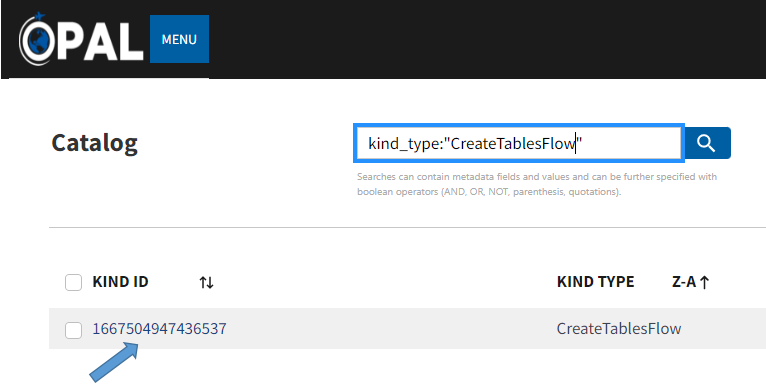
Note: The Catalog can be accessed through File -> Hub Control Panel -> Services -> Opal-Catalog

## Remove the Run from the Catalog

In [ ]:
opal.publish.delete(latest_create_tables_run.id)
# Note that the data are still stored in MinIO 
# even after deleting the run from the catalog.

Note: The Catalog is generally maintained through a different process, see `~/opal/data-engineering-resources/readme.md`

# Delete Run Data From MinIO

In [ ]:
# Note the state of the Run before deleting the Data
print('--tags')
print(latest_create_tables_run.tags)
print('--datafiles')
print(latest_create_tables_run.data.data_files)
print('--metadata')
print(latest_create_tables_run.data)
print(latest_create_tables_run.data.metadata_dictionary)

In [ ]:
opal.flow.flow_script_utils.delete_run_data(latest_create_tables_run)

In [ ]:
create_tables_runs = metaflow.Flow("CreateTablesFlow")
latest_create_tables_run = create_tables_runs.latest_successful_run

# Note the state of the Run after deleting the Data
# There is an additional tag 'no_data' but the original metadata from the run 
# was saved
print('--tags')
print(latest_create_tables_run.tags)
print('--datafiles')
print(latest_create_tables_run.data.data_files)
print('--metadata')
print(latest_create_tables_run.data)
print(latest_create_tables_run.data.metadata_dictionary)

# View the Card from the Run

In [ ]:
get_cards(latest_create_tables_run['end'].task)